In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-08-04 18:29:21--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.03s   

2020-08-04 18:29:21 (2.36 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [ ]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

2.3.0


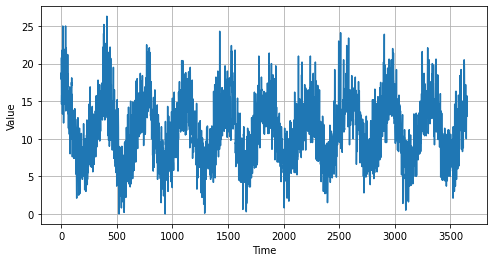

In [ ]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1
    
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(8,4))
plot_series(time,series)

In [ ]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

def windowed_dataset_dnn(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) #differences
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Model 1
Deep Neural Network

3 layers (20 --> 10 --> 1)



In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

train_set = windowed_dataset_dnn(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])
# Create learning rate schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
# Set up the optimizer
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
# Compile the model with Huber loss
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
(2500,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 0s 28ms/step - loss: 6.7688 - mae: 7.2628
Epoch 2/100
10/10 [==============================] - 0s 22ms/step - loss: 6.7674 - mae: 7.2614
Epoch 3/100
10/10 [==============================] - 0s 23ms/step - loss: 6.7652 - mae: 7.2592
Epoch 4/100
10/10 [==============================] - 0s 19ms/step - loss: 6.7626 - mae: 7.2566
Epoch 5/100
10/10 [==============================] - 0s 29ms/step - loss: 6.7595 - mae: 7.2535
Epoch 6/100
10/10 [==============================] - 0s 30ms/step - loss: 6.7561 - mae: 7.2501
Epoch 7/100
10/10 [==============================] - 0s 26ms/step - loss: 6.7522 - mae: 7.2462
Epoch 8/100
10/10 [==============================] - 0s 25ms/step - loss: 6.7479 - mae: 7.2418
Epoch 9/100
10/10 [==============================] - 0s 26ms/step - loss: 6.7429 - mae: 7.2369
Epoch 10/100
10/10 [==============================] - 0s 25ms/step - loss: 6.7374 - mae: 7.2314
Epoch 11/100
10/10 [=============================

(1e-08, 0.0001, 0.0, 60.0)

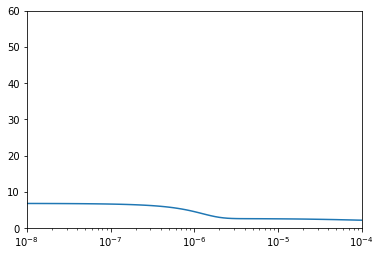

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

# Model 2
Recurrent Neural Networks for time series
*   Window_size = 64
*   batch_size = 256





In [ ]:
tf.keras.backend.clear_session()
shuffle_buffer_size = 1000
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
   tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
# Create learning rate schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
# Compile the model with Huber loss
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.summary()
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
____________________

(1e-08, 0.0001, 0.0, 60.0)

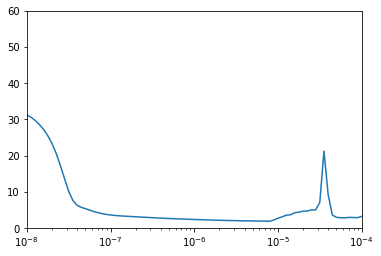

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

# Model 3
Recurrent Neural Networks for time series
*   Window_size = 60
*   batch_size = 100



In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#smaller window_size and batch_size
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding="causal",
                               activation="relu", input_shape=[None,1]),
        tf.keras.layers.LSTM(60, return_sequences=True),
        tf.keras.layers.LSTM(60, return_sequences=True),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*400) # rescale the values into between 0 and 400
])

# Set up the optimizer
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
# Compile the model with Huber loss
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.summary()

# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS
history = model.fit(train_set, epochs=150)

Epoch 1/150
25/25 [==============================] - 3s 107ms/step - loss: 9.9820 - mae: 10.4700
Epoch 2/150
25/25 [==============================] - 3s 107ms/step - loss: 2.5294 - mae: 2.9922
Epoch 3/150
25/25 [==============================] - 3s 105ms/step - loss: 1.9501 - mae: 2.4046
Epoch 4/150
25/25 [==============================] - 3s 112ms/step - loss: 1.8618 - mae: 2.3151
Epoch 5/150
25/25 [==============================] - 3s 109ms/step - loss: 1.8215 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 3s 107ms/step - loss: 1.7908 - mae: 2.2418
Epoch 7/150
25/25 [==============================] - 3s 110ms/step - loss: 1.7686 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 3s 108ms/step - loss: 1.7413 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 3s 107ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 3s 108ms/step - loss: 1.7000 - mae: 2.1483
Epoch 11/150
25/25 [==================

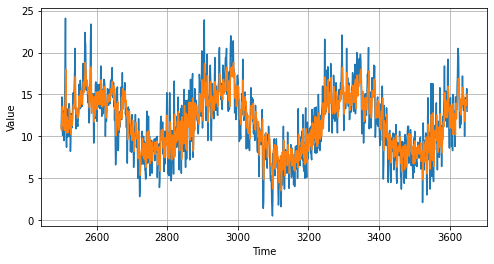

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(8,4))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())
print(rnn_forecast)

[11.328999  10.703278  12.122135  ... 13.6022835 13.795011  15.007327 ]
